# Substantial Improvement in Credit Scoring of Lending Club Loans

### Table of Contents

* [Business Understanding](#chapter1)
* [Data Understanding](#chapter2)
* [Data Preparation](#chapter3)
    * [Data Extraction](#section31)
    * [Selection of Relevant Loan Characteristics](#section32)
    * [Data Cleaning](#section33)
    * [Data Visualization and Handling of Outliers](#section34)
* [Model Development](#chapter4)
    * [Performance of Fico Scoring](#section41)
    * [Building Predictive Model](#section42)
* [Model Evaluation](#chapter5)
* [Conclusion](#chapter6)

## Business Understanding<a class="anchor" id="chapter1"></a>

LendingClub uses FICO scores to assess the credit creditworthiness of its clients like many other lenders. According to the online article [LendingClub: FICO's New Model Won't Help](https://www.pymnts.com/consumer-finance/2020/lendingclub-president-fico-model-wont-save-credit-scoring-dinosaur/) - << the president of LendingClub, said that traditional credit scoring — such as through the FICO credit score — misrepresents creditworthiness of individuals >>.

LendingClub is a leading lender in the USA. It publishes quarterly loan data online and thus offers its audience the possibility to evaluate the loans. The current work will show that FICO scores indeed misrepresent creditworthiness of individuals as a lot of loans with good FICO scores get into trouble. Most importanly, this work uses Data Science techniques to develop a substancial improvement in credit scoring of LendingClub loans.  

Let's assume that the last FICO rate range score is used to monitor credit risk and predict the final loan status which is "Fully Paid" for good loan or "Default", "Charged Off","Late (31-120 days)" for bad loan. This work will focus on following main objectives

- Use ML metrics "accuracy" and "f1-score" to show the limitation of the FICO credit scoring model
- Create an ML model which improves the FICO credit scoring model significantly on LendingClub loan data
- Demontrate the truthfulness and reliability of the model

Here are some ML metrics which will be helpfull in this context:

**accuracy = (TP + TN) /(TP+FP+TN+FN)**

**presicion = TP/(TP+FP)**

**recall = TP/(TP+FN)**

**F1 = 2.0 x precision x recall/(precision + recall)**

**ROC-Curve: measure of truthfulness and reliability of the model**

- TP: True positives - number of good loans ("Fully Paid") which have been predicted good 
- TN: True negatives - number of bad loans (not "Fully Paid") which have been predicted bad 
- FP: False positives - number of good loans ("Fully Paid") which have been predicted bad
- FN: False negatives - number of bad loans (not "Fully Paid") which have been predicted good


## Data Understanding<a class="anchor" id="chapter2"></a>

LendingClub gives free access to loan data on its web page [LendingClub Data](https://www.lendingclub.com/statistics/additional-statistics?). Loan data is available in csv format and updated at the end of each quarter. The datasets in this work contain LendingClub loan data of Q1-2019, Q2-2019, Q3-2019, Q4-2019, Q1-2020 and Q2-2020.

The data contains historical loans with loan stattus "Fully Paid", "Charged-Off","Late (31-120 days)", "Default". Those historical loans could be used to learn about good or bad loans. Non-historical or current loans have the loan status "Current" or "Issued" and "Late (16-30 days)". Current loans are those for which the final status should be predicted. More precisely it should be predicted whether the final status will be "Fully Paid" or not.

The dataset contains 116863 historical loans and 519562 current loans on 150 features.


## Data Preparation<a class="anchor" id="chapter3"></a> 

In [1]:
# Import modules

import pandas as pd
import numpy as np
import datetime
#import time
#import math
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,12)

### Data Extraction<a class="anchor" id="section31"></a>  

***Data Loading***

In [2]:
## Loading data from csv-zipped files

def load_data():
    """
    Description: read loan data stored in compressed csv-files 
    Input: None
    Output: df - loan data as DataFrame
    """
    csv_files = ["LoanStats_securev1_2020Q2.csv.zip", "LoanStats_securev1_2020Q1.csv.zip",
                 "LoanStats_securev1_2019Q4.csv.zip", "LoanStats_securev1_2019Q3.csv.zip", 
                 "LoanStats_securev1_2019Q2.csv.zip", "LoanStats_securev1_2019Q1.csv.zip"]
    df = None
    initial = False
    for filename in csv_files:
        if not initial:
            df = pd.read_csv(filename, compression="zip", skiprows=1, low_memory=False)
            initial = True
        else:
            ldf = pd.read_csv(filename, compression="zip", skiprows=1, low_memory=False)
            df = pd.concat([df,ldf])
    return df

df = load_data()
print(df.shape)
display(df.head(3))

(636437, 150)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,169227883,NaN,25000.0,25000.0,25000.0,36 months,18.24%,906.83,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,169218684,NaN,5600.0,5600.0,5600.0,36 months,10.81%,182.84,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,169165183,NaN,15000.0,15000.0,15000.0,36 months,9.56%,480.92,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


***Splitting loan data in historical loans and current loans***

In [3]:
## Split loan data in historical loans and current loans based on loan status
def split_loan_data(ldf=df, verbose=0):
    """
    Description: Splits loan data in historical loans and current loans based on loan status
    Input: 
        ldf - DataFrame containing all loan data
        verbose - flag to control the output of information the execution
    Output: hist_loan_df, current_df - historical loans and current loans as DataFrames
    """
    ## Historical loans - useful to create ML  model
    hist_loan_df = ldf[ldf.loan_status.isin(["Fully Paid","Charged Off","Late (31-120 days)", "Default"])]
    if verbose > 0:
        print(f"Number of historical loans: {hist_loan_df.shape[0]}")
        display(hist_loan_df.head(3))

        print("=======")
    
    ## Current loans - where the ML prediction will be used
    current_df = ldf[ldf.loan_status.isin(["Current", "Issued","In Grace Period", "Late (16-30 days)"])]
    if verbose > 0:
        print(f"Number of current loans: {current_df.shape[0]}")
        display(current_df.head(3))
          
    return hist_loan_df, current_df
          
hist_loan_df, current_df  = split_loan_data(ldf=df,verbose=0)

### Selection of Relevant Loan Characteristics<a class="anchor" id="section32"></a>  

***Relevant features are the common characteristics of loans which are considered when assessing credit risk***

In [4]:
## Preselected relevant columns which will not be dropped for technical reasons 
## unless it turns out that they are considered to be redundant or cumbersome

relevant_columns = ["loan_amnt","term","int_rate","home_ownership","annual_inc","verification_status",\
                    "loan_status","purpose","emp_length", "percent_bc_gt_75","dti", "fico_range_high",\
                    "fico_range_low","last_fico_range_high","last_fico_range_low","addr_state","zip_code"]
relevant_columns

['loan_amnt',
 'term',
 'int_rate',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'emp_length',
 'percent_bc_gt_75',
 'dti',
 'fico_range_high',
 'fico_range_low',
 'last_fico_range_high',
 'last_fico_range_low',
 'addr_state',
 'zip_code']

***Preselected list of fields which are not relevant for credit scoring***

- Post-event data (payment related)
- Recovery related data
- Meta data like id, url
- Dates

In [5]:
## Preselect a list of field which are not relevant for credit scoring
def get_irrelevant_columns(initial_list=["id", "url","earliest_cr_line","zip_code"]):
    """
    Description: Preselect a list of field which are not relevant for credit scoring
    Input: initial_list - Initial list containing irrelevant columns 
    Output: irrelevant_columns - list of field which are not relevant for credit scoring
    """
    irrelevant_columns = initial_list
    irrelevant_columns.extend([col for col in df.columns.to_list() if \
                          (col.find("pymnt")>-1 or col.find("coll")>-1 or \
                           col.find("recover")>-1 or col[-2:]=="_d" or \
                           col.find("fund")>-1 or col.find("total_rec")>-1 or\
                           col.find("title")>-1 or col.find("grade")>-1 or \
                           col.find("out_prncp")>-1
                          ) ])

    #print(len(irrelevant_columns))
    return irrelevant_columns

irrelevant_columns = get_irrelevant_columns(initial_list=["id", "url","earliest_cr_line","zip_code"])
print(f"These {len(irrelevant_columns)} fields are irrelevant for the predictive model")
display(irrelevant_columns)

These 28 fields are irrelevant for the predictive model


['id',
 'url',
 'earliest_cr_line',
 'zip_code',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'sub_grade',
 'emp_title',
 'issue_d',
 'pymnt_plan',
 'title',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'sec_app_collections_12_mths_ex_med']

***Identifying features/columns to be dropped: Step 1 - missing values columns***

Columns with null-values/missing-values will not be helpful for prediction and should therefore be dropped. Only columns which are filled at at least 99% are considered.

In [6]:
def get_missing_value_columns(ldf, threshold=0.01, verbose=0):
    """
    Description: Select a list of fields with significantly many null-values in order to exclude them from credit scoring prediction
    Input: 
        ldf - DataFrame containing loan data
        threshold - Significance level for the acceptable number of missing values
        verbose - flag to control the output of information the execution
    Output: missing_val_cols - list of fields with significantly many null-values
    """
    missing_val_count = ldf.isnull().sum()
    if verbose > 0:
        print("Null values count")
        display(missing_val_count)
        
    if threshold >= 1:
        threshold=threshold/100.0
        
    ## Columns with more than 1% missing values in current loans will not be considered for prediction
    missing_val_cols = [col for col in ldf.columns.to_list() if missing_val_count.at[col] > threshold*ldf.shape[0]]
    return missing_val_cols

missing_val_cols = get_missing_value_columns(current_df, threshold=0.01, verbose=0)
print(f"The {len(missing_val_cols)} columns right above having at least 1% of null values will be not be taken into account for predictive model")
display(missing_val_cols)


The 55 columns right above having at least 1% of null values will be not be taken into account for predictive model


['member_id',
 'emp_title',
 'emp_length',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'mths_since_rcnt_il',
 'il_util',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_tl_120dpd_2m',
 'percent_bc_gt_75',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 

***Identifying features/columns to be dropped: Step 2 - quasi constant columns***

Columns having the same value for at least 80% are considered as quasi constant and will not be taken into account in predictive model

In [7]:
def get_quasi_constant_columns(ldf, threshold=0.85, verbose=0):
    """
    Description: Columns having the same value for at least 80% are considered as quasi constant and will not be taken into account in predictive model
    Input: 
        ldf - DataFrame containing loan data
        threshold - Significance level for the acceptable number of constant values
        verbose - flag to control the output of information the execution
    Output: quasi_constant_cols - list of fields with the same value for a significant level
    """

    ## Columns having the same value for at least 80% in current loans are considered as quasi constant and will not be considered
    quasi_constant_cols= []
    for col in ldf.columns.to_list():
        if ldf[col].value_counts().max() >= threshold*ldf.shape[0]:
            quasi_constant_cols.append(col)
            if verbose > 0:
                print(f"{col}:{ldf[col].value_counts().max()}")
                
    return quasi_constant_cols
   
quasi_constant_cols = get_quasi_constant_columns(current_df, threshold=0.85, verbose=0)
print(f"List of {len(quasi_constant_cols)} quasi constant fileds for current loans")
quasi_constant_cols

List of 25 quasi constant fileds for current loans


['loan_status',
 'pymnt_plan',
 'delinq_2yrs',
 'pub_rec',
 'initial_list_status',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'tax_liens',
 'hardship_flag',
 'debt_settlement_flag']

In [8]:
## Columns having the same value for at least 85% in historical loans are considered as quasi constant and will not be considered
quasi_constant_hist_cols = get_quasi_constant_columns(hist_loan_df, threshold=0.85, verbose=0)
print(f"List of {len(quasi_constant_hist_cols)} quasi constant fileds for historical loans")
quasi_constant_hist_cols

List of 23 quasi constant fileds for historical loans


['pymnt_plan',
 'delinq_2yrs',
 'pub_rec',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'tax_liens',
 'hardship_flag',
 'debt_settlement_flag']

In [9]:
## Put all fields together which will be dropped 

def get_all_to_drop_columns(hist_loan_df, current_df, initial_list=[], threshold_MV=0.01, threshold_C=0.85, verbose=0):
    """
    Description: Put all fields together which will be dropped s 
    
    Input: 
        hist_loan_df - Historical loans
        current_df - Current loans
        initial_list - Initial list of irrelevant characteristics
        threshold_MV -  Significance level for the acceptable number of missing values
        threshold_C - Significance level for the acceptable number of constant values
        verbose - flag used to control the debugging
        
    Output: all_to_drop_columns - list of all columns which will be dropped
    """
    all_to_drop_columns = get_irrelevant_columns(initial_list=initial_list)
    
    missing_val_cols = get_missing_value_columns(current_df, threshold=threshold_MV, verbose=verbose)
    quasi_constant_cols = get_quasi_constant_columns(current_df, threshold=threshold_C, verbose=verbose)
    quasi_constant_hist_cols = get_quasi_constant_columns(hist_loan_df, threshold=threshold_C, verbose=verbose)
    
    all_to_drop_columns.extend(missing_val_cols)
    all_to_drop_columns.extend(quasi_constant_cols)
    all_to_drop_columns.extend(quasi_constant_hist_cols)
    
    all_to_drop_columns = list(set(all_to_drop_columns))
    all_to_drop_columns = [col for col in all_to_drop_columns if col not in relevant_columns]
    
    if verbose > 0:
        print(f"list of {len(all_to_drop_columns)} to drop fields")
    
    return all_to_drop_columns

all_to_drop_columns = get_all_to_drop_columns(hist_loan_df=hist_loan_df, current_df=current_df, \
                                              initial_list=["id", "url","earliest_cr_line","zip_code"],\
                                              threshold_MV=0.02, threshold_C=0.85, verbose=0)
print(f"list of all {len(all_to_drop_columns)} to drop fields...")
display(all_to_drop_columns)

list of all 88 to drop fields...


['delinq_2yrs',
 'mths_since_recent_inq',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'hardship_reason',
 'orig_projected_additional_accrued_interest',
 'tax_liens',
 'url',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'hardship_status',
 'total_rec_late_fee',
 'sec_app_open_acc',
 'total_rec_int',
 'num_tl_30dpd',
 'out_prncp',
 'out_prncp_inv',
 'il_util',
 'next_pymnt_d',
 'hardship_dpd',
 'member_id',
 'emp_title',
 'settlement_percentage',
 'title',
 'last_credit_pull_d',
 'last_pymnt_d',
 'issue_d',
 'mths_since_recent_bc_dlq',
 'initial_list_status',
 'num_tl_90g_dpd_24m',
 'debt_settlement_flag_date',
 'desc',
 'acc_now_delinq',
 'hardship_type',
 'hardship_end_date',
 'mo_sin_old_il_acct',
 'funded_amnt_inv',
 'id',
 'earliest_cr_line',
 'hardship_flag',
 'annual_inc_joint',
 'mths_since_last_major_derog',
 'pymnt_plan',
 'sec_app_mort_acc',
 'funded_amnt',
 'dti_joint',
 'collection_recovery_fee',
 'policy_code',
 'application_type',
 'hardship_length'

### Data Cleaning <a class="anchor" id="section33"></a>  

Cleaning term, emp_title, emp_length, int_rate, revol_util 
and filling missing values with some dummy values

In [10]:
def clean_data(hist_loan_df, current_df, initial_list=[], threshold_MV=0.01, threshold_C=0.85, \
               use_zip_code=False, zip_code_type=int, verbose=0):
    
    """
    Description: Put all fields together which will be dropped s 
    
    Input: 
        hist_loan_df - Historical loans
        current_df - Current loans
        initial_list - Initial list of irrelevant characteristics
        threshold_MV -  Significance level for the acceptable number of missing values
        threshold_C - Significance level for the acceptable number of constant values
        use_zip_code - Flag indicating whether the field "zip_code" should be used for prediction or not
        zip_code_type - Zip code could be used as numerical value or categorical value (int or str)
        verbose - flag used to control the debugging
        
    Output: clean_hist_loan_df - Clean data as DataFrame
    """

    clean_hist_loan_df = hist_loan_df.copy()
    
    clean_hist_loan_df["int_rate"] = clean_hist_loan_df.int_rate.apply(lambda s: float(s.split("%")[0]) if type(s)==str else s)
    clean_hist_loan_df["term"] = clean_hist_loan_df.term.apply(lambda s: float(s.split()[0]) if type(s)==str else s)
    clean_hist_loan_df["revol_util"] = clean_hist_loan_df.revol_util.apply(lambda s: float(s.split("%")[0]) if type(s)==str else s)

    clean_hist_loan_df.percent_bc_gt_75.fillna(clean_hist_loan_df.percent_bc_gt_75.mean(),inplace=True)
    clean_hist_loan_df.dti.fillna(clean_hist_loan_df.dti.mean(),inplace=True)
    clean_hist_loan_df.dti.fillna(clean_hist_loan_df.dti.mean(),inplace=True)
    clean_hist_loan_df.avg_cur_bal.fillna(clean_hist_loan_df.avg_cur_bal.mean(),inplace=True)
    clean_hist_loan_df.all_util.fillna(clean_hist_loan_df.all_util.mean(),inplace=True)
    clean_hist_loan_df.revol_util.fillna(clean_hist_loan_df.revol_util.mean(),inplace=True)

    clean_hist_loan_df["emp_length"].fillna("< 1 year",inplace=True)
    emp_len_map = {f"{k} years":k for k in range(15)}
    emp_len_map.update({f"{k}":k for k in range(15)})
    emp_len_map.update({k:k for k in range(15)})
    emp_len_map["< 1 year"] = 0
    emp_len_map["1 year"] = 1
    emp_len_map["10+ years"] = 11
    clean_hist_loan_df["emp_length"] = clean_hist_loan_df.emp_length.apply(lambda s: emp_len_map[s])
       
    if use_zip_code :
        if "zip_code" in initial_list:
            initial_list.remove("zip_code")
        if "zip_code" not in relevant_columns:
            relevant_columns.extend(["zip_code"])
        clean_hist_loan_df["zip_code"] = clean_hist_loan_df.zip_code.apply(lambda s: zip_code_type(s[:3]) if type(s)==str else s)
    else:
        if "zip_code" not in initial_list:
            initial_list.extend(["zip_code"])
        if "zip_code" in relevant_columns:
            relevant_columns.remove("zip_code") 
        
    all_to_drop_columns = get_all_to_drop_columns(hist_loan_df=hist_loan_df, current_df=current_df,\
                                                  initial_list=initial_list,threshold_MV=threshold_MV, \
                                                  threshold_C=threshold_C, verbose=verbose)

    clean_hist_loan_df.drop(all_to_drop_columns, axis=1, inplace=True)
    null_val_columns = clean_hist_loan_df.columns[clean_hist_loan_df.isnull().any()].tolist()
    for col in null_val_columns:
        if col in clean_hist_loan_df.head(1).select_dtypes(include=["object"]).columns.to_list():
            clean_hist_loan_df[col].fillna("Unknown",inplace=True)
        else:
            clean_hist_loan_df[col].fillna(clean_hist_loan_df[col].mean(),inplace=True)

    loan_status_map = {"Fully Paid":1,"Charged Off":0, "Late (31-120 days)":0, "Default":0 }
    clean_hist_loan_df["loan_status"] = clean_hist_loan_df.loan_status.apply(lambda s: loan_status_map[s])

    return clean_hist_loan_df

clean_hist_loan_df= clean_data(hist_loan_df, current_df, initial_list=["id", "url","earliest_cr_line","zip_code"],\
                               threshold_MV=0.02, threshold_C=0.85, use_zip_code=False, zip_code_type=str, verbose=0)
display(clean_hist_loan_df.head())
print("Categorical variables")
display(clean_hist_loan_df.select_dtypes(include=["object"]))
print("Numerical variables")
display(clean_hist_loan_df.select_dtypes(exclude=["object"]))

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
4,25000.0,60.0,19.95,661.66,2,MORTGAGE,70000.0,Not Verified,1,house,...,11.0,3.0,6.0,2.0,69.2,0.0,217138.0,45384.0,4200.0,0.0
21,40000.0,36.0,8.46,1261.97,4,RENT,142000.0,Source Verified,1,major_purchase,...,8.0,5.0,8.0,1.0,100.0,0.0,96384.0,1636.0,60000.0,11384.0
32,2000.0,36.0,15.40,69.73,11,RENT,152000.0,Not Verified,1,debt_consolidation,...,13.0,3.0,10.0,2.0,100.0,100.0,287860.0,220424.0,41800.0,246060.0
59,6000.0,36.0,13.33,203.12,11,MORTGAGE,73000.0,Not Verified,1,debt_consolidation,...,21.0,9.0,14.0,8.0,91.5,0.0,400009.0,249026.0,3600.0,227470.0
131,15000.0,60.0,16.08,365.41,11,RENT,70000.0,Source Verified,1,debt_consolidation,...,13.0,11.0,14.0,2.0,95.5,20.0,98951.0,43965.0,34100.0,42751.0


Categorical variables


,home_ownership,verification_status,purpose,addr_state
4,MORTGAGE,Not Verified,house,UT
21,RENT,Source Verified,major_purchase,WA
32,RENT,Not Verified,debt_consolidation,NJ
59,MORTGAGE,Not Verified,debt_consolidation,NC
131,RENT,Source Verified,debt_consolidation,NY
...,...,...,...,...
115657,RENT,Not Verified,other,MI
115658,MORTGAGE,Not Verified,credit_card,FL
115670,MORTGAGE,Not Verified,home_improvement,FL
115672,MORTGAGE,Source Verified,debt_consolidation,CA


Numerical variables


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,fico_range_low,fico_range_high,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
4,25000.0,60.0,19.95,661.66,2,70000.0,1,6.29,660.0,664.0,...,11.0,3.0,6.0,2.0,69.2,0.000000,217138.0,45384.0,4200.0,0.0
21,40000.0,36.0,8.46,1261.97,4,142000.0,1,3.90,800.0,804.0,...,8.0,5.0,8.0,1.0,100.0,0.000000,96384.0,1636.0,60000.0,11384.0
32,2000.0,36.0,15.40,69.73,11,152000.0,1,34.83,700.0,704.0,...,13.0,3.0,10.0,2.0,100.0,100.000000,287860.0,220424.0,41800.0,246060.0
59,6000.0,36.0,13.33,203.12,11,73000.0,1,8.53,695.0,699.0,...,21.0,9.0,14.0,8.0,91.5,0.000000,400009.0,249026.0,3600.0,227470.0
131,15000.0,60.0,16.08,365.41,11,70000.0,1,29.56,705.0,709.0,...,13.0,11.0,14.0,2.0,95.5,20.000000,98951.0,43965.0,34100.0,42751.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115657,20000.0,36.0,13.56,679.29,0,55000.0,1,32.75,795.0,799.0,...,20.0,8.0,19.0,4.0,100.0,0.000000,116838.0,37294.0,50500.0,50438.0
115658,9600.0,36.0,7.56,298.89,0,64000.0,1,14.27,735.0,739.0,...,14.0,6.0,13.0,3.0,100.0,11.100000,278473.0,12215.0,45500.0,20412.0
115670,5000.0,36.0,13.56,169.83,0,48000.0,1,8.28,735.0,739.0,...,16.0,3.0,8.0,0.0,90.5,28.693083,88613.0,9182.0,0.0,11413.0
115672,16000.0,36.0,16.14,563.62,11,32000.0,0,20.89,685.0,689.0,...,14.0,8.0,13.0,3.0,93.3,37.500000,34200.0,17066.0,16400.0,0.0


### Data Visualization and Handling of Outliers<a class="anchor" id="section34"></a>  

In [11]:
clean_hist_loan_df.select_dtypes(exclude=["object"]).describe()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,fico_range_low,fico_range_high,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,116863.000000,116863.000000,116863.000000,116863.000000,116863.000000,1.168630e+05,116863.000000,116863.000000,116863.000000,116863.000000,...,116863.000000,116863.000000,116863.000000,116863.000000,116863.000000,116863.000000,1.168630e+05,1.168630e+05,1.168630e+05,1.168630e+05
mean,15324.269230,42.507107,13.622291,458.132695,5.369356,8.708166e+04,0.773829,19.829953,708.603707,712.604024,...,13.590709,5.107288,11.742014,2.390928,95.008687,28.693083,2.068563e+05,5.668913e+04,2.940613e+04,5.014246e+04
std,10193.178435,10.669072,5.364588,296.676489,4.383620,1.101335e+05,0.418353,20.704072,36.688325,36.689507,...,8.324348,3.287982,5.985445,2.028943,8.511852,33.014056,1.995271e+05,5.671786e+04,2.809792e+04,5.063369e+04
min,1000.000000,36.000000,6.000000,28.770000,0.000000,0.000000e+00,0.000000,0.000000,660.000000,664.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7425.000000,36.000000,8.810000,238.010000,1.000000,5.000000e+04,1.000000,11.630000,680.000000,684.000000,...,8.000000,3.000000,8.000000,1.000000,92.900000,0.000000,6.129450e+04,2.195150e+04,1.090000e+04,1.727850e+04
50%,12500.000000,36.000000,12.980000,377.090000,5.000000,7.110000e+04,1.000000,17.910000,700.000000,704.000000,...,12.000000,4.000000,11.000000,2.000000,100.000000,20.000000,1.419080e+05,4.137000e+04,2.120000e+04,3.771600e+04
75%,21000.000000,60.000000,16.950000,622.680000,11.000000,1.010000e+05,1.000000,25.180000,730.000000,734.000000,...,17.000000,7.000000,15.000000,3.000000,100.000000,50.000000,2.993875e+05,7.220450e+04,3.900000e+04,6.764200e+04
max,40000.000000,60.000000,30.990000,1676.230000,11.000000,9.100000e+06,1.000000,999.000000,845.000000,850.000000,...,122.000000,58.000000,84.000000,19.000000,100.000000,100.000000,4.542835e+06,1.357906e+06,1.058000e+06,1.650162e+06


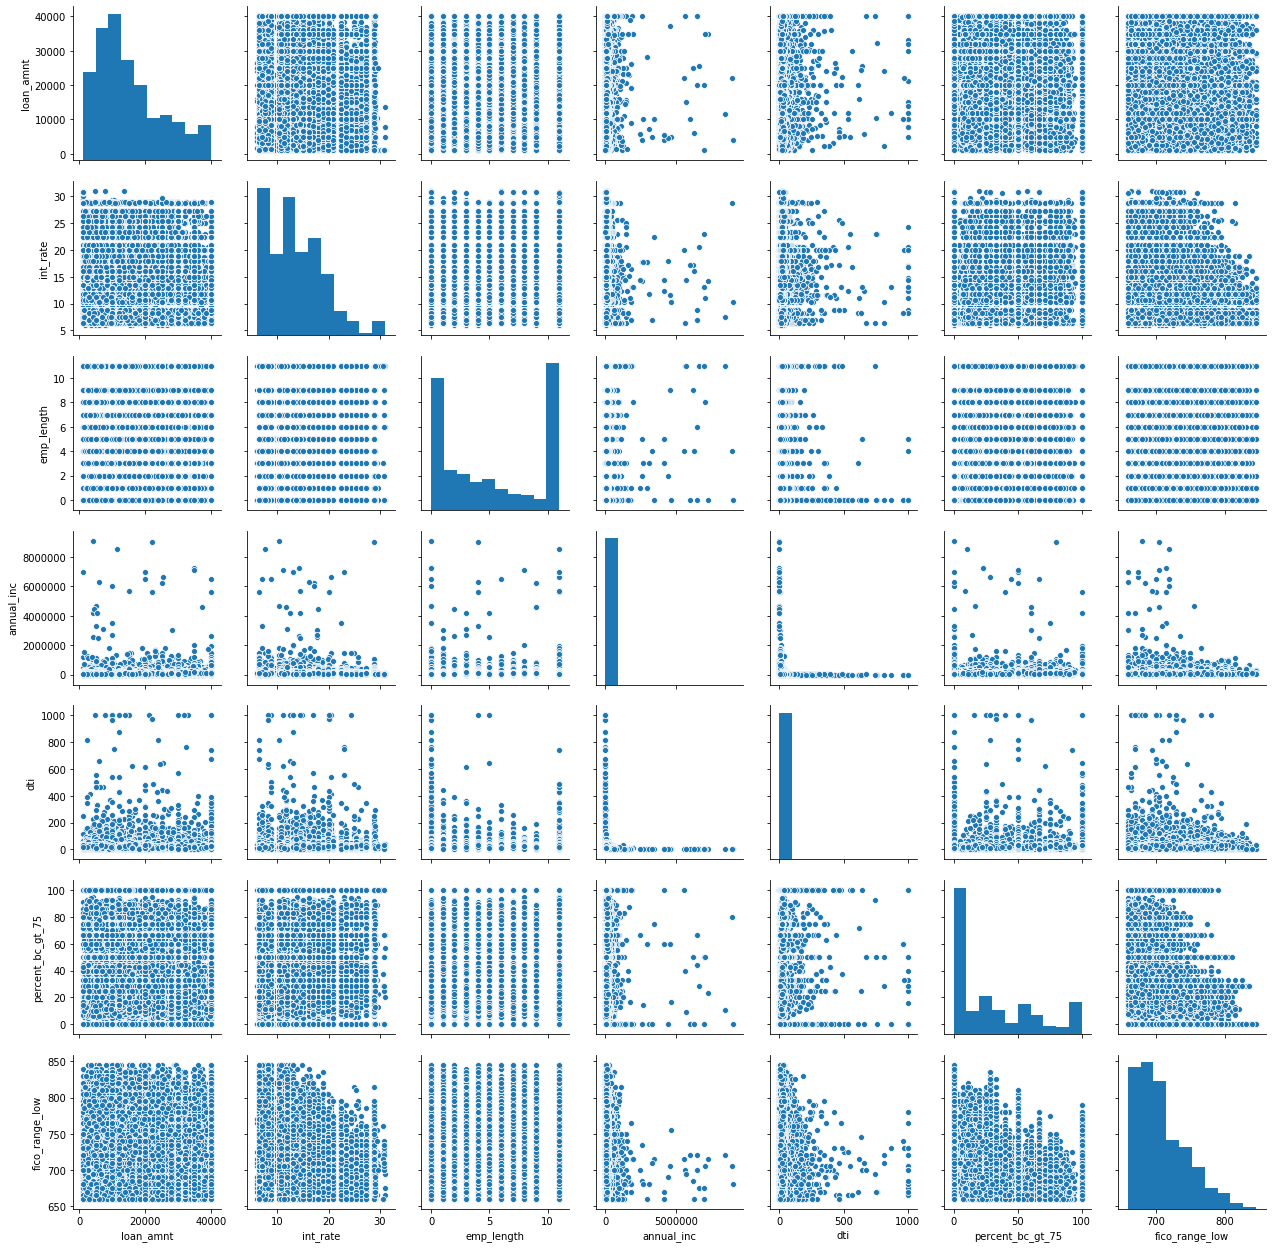

In [12]:
#num_columns = clean_hist_loan_df.head().select_dtypes(exclude=["object"]).columns[:10].to_list()
num_columns = ["loan_amnt","int_rate","emp_length","annual_inc","dti","percent_bc_gt_75","fico_range_low"]
sns.pairplot(clean_hist_loan_df[num_columns])
#pd.plotting.scatter_matrix(hist_loan_df_num)

In [13]:
def drop_outliers(ldf, amplifier=5.0):
    
    """
    Description: Dropping outliers above a threshold determined by the 3rd quartile multiplied with the amplifier
    
    Input: 
        ldf - DataFrame containing the data to be cleaned
        amplifier - factor by which the threshold will be amplified
        
    Output: out_df - Clean data as DataFrame
    """
    
    out_df = ldf.copy()
    ldf_stat = out_df.select_dtypes(exclude=["object"]).describe()
    for col in ldf_stat.columns:
        threshold = amplifier*ldf_stat.loc["75%", col]
        out_df = out_df[out_df[col] <= threshold ]
    return out_df
    
transformed_hist_loan_df = drop_outliers(ldf=clean_hist_loan_df, amplifier=5.0)


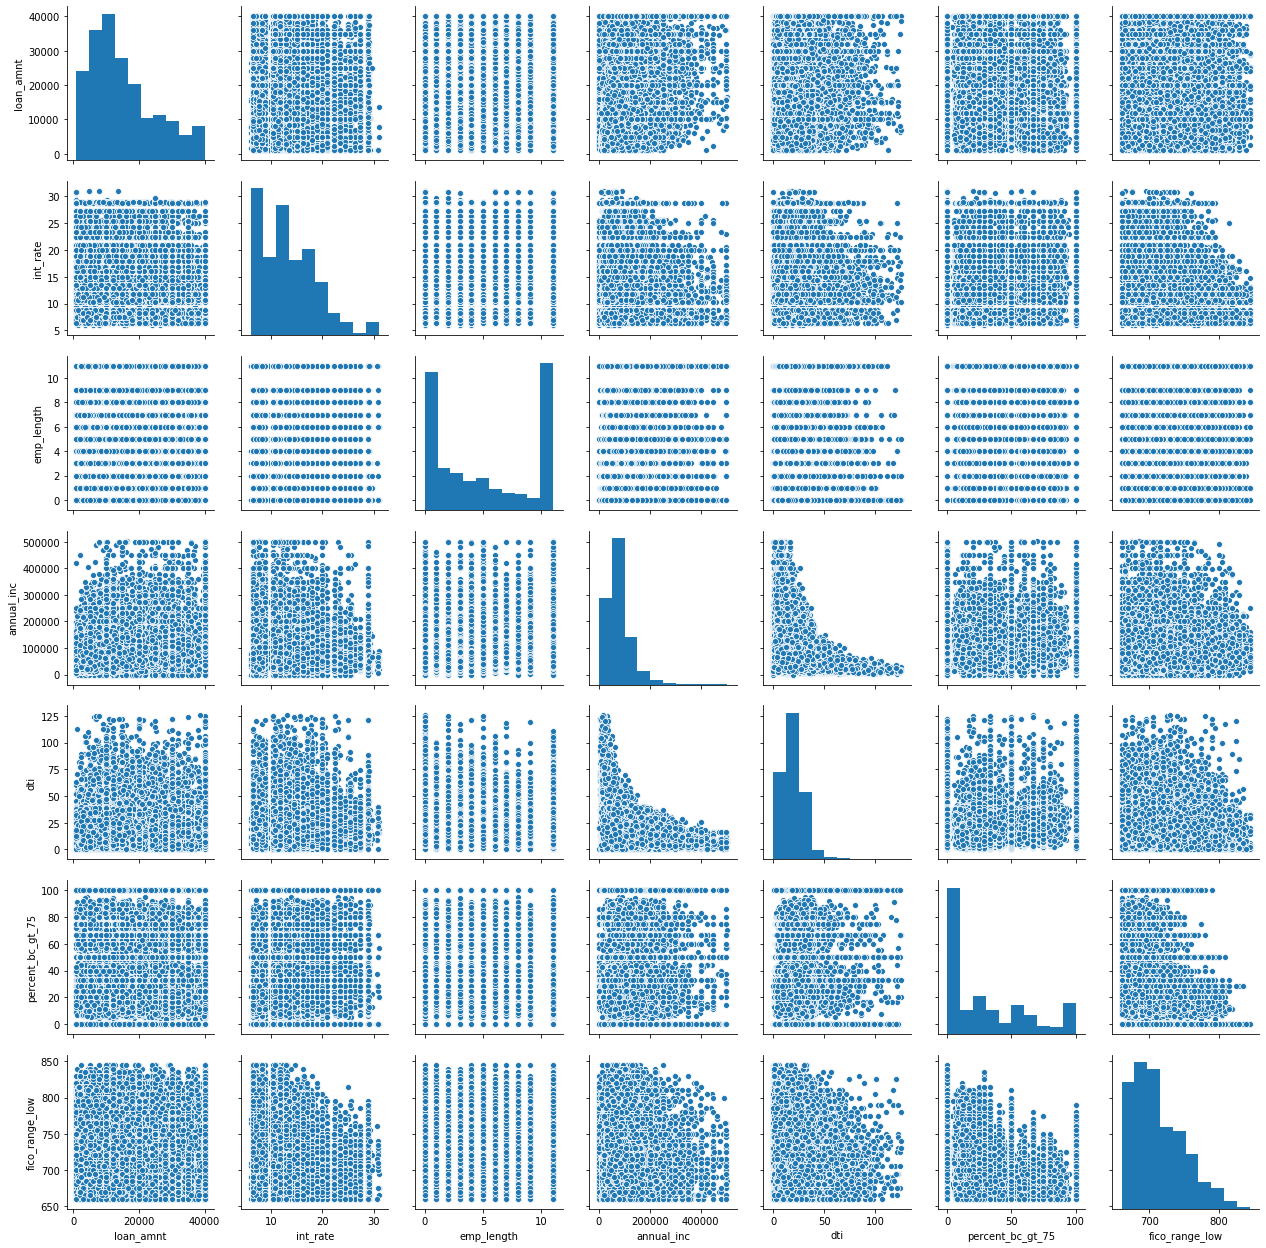

In [14]:
num_columns = ["loan_amnt","int_rate","emp_length","annual_inc","dti","percent_bc_gt_75","fico_range_low"]
sns.pairplot(transformed_hist_loan_df[num_columns])
#pd.plotting.scatter_matrix(hist_loan_df_num)

***An improvement on the distribution of the data is visible on the plot right above compared to the previous one -\
especially for annual_inc and dti.***

***The following visualization using T-SNE will show the real structure of the loan data. It will show the data could \
not be classified using a linear model.*** 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1684 samples in 0.003s...
[t-SNE] Computed neighbors for 1684 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1684
[t-SNE] Computed conditional probabilities for sample 1684 / 1684
[t-SNE] Mean sigma: 8097.989133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.842033
[t-SNE] KL divergence after 1000 iterations: 0.735466


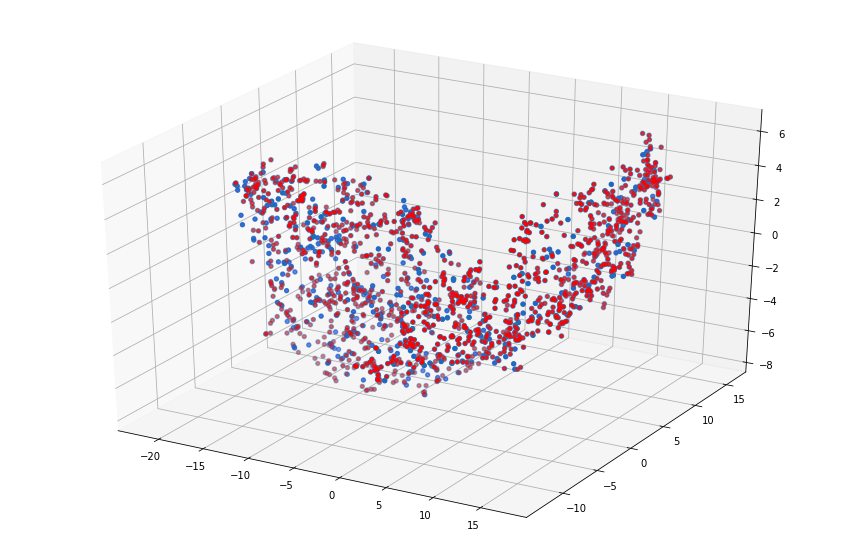

<Figure size 1080x720 with 0 Axes>

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## buidlding a T-SNE model

def build_tsne_model(ldf):
    
    """
    Description: buid and train a T-SNE model
    
    Input: 
        ldf - DataFrame containing clean data to be visualized
        
    Output: sample_hist_loan_df, tsne - sample data and trained model
    """    
    
    
    sample_hist_loan1 = ldf[ldf.loan_status == 1].sample(frac=0.02, random_state=42)
    sample_hist_loan2 = ldf[ldf.loan_status == 0].sample(frac=0.02, random_state=42)
    #print(sample_hist_loan1.shape)
    #print(sample_hist_loan2.shape)
    sample_hist_loan_df = pd.concat([sample_hist_loan1,sample_hist_loan2])
    #sample_hist_loan_df = sample_hist_loan_df.to_frame()
    sample_hist_loan_df

    tsne = TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1, \
                random_state=42).fit_transform(sample_hist_loan_df.select_dtypes(exclude=["object"]).drop(["loan_status"],axis=1))
    return sample_hist_loan_df, tsne

sample_hist_loan_df, tsne =  build_tsne_model(ldf=transformed_hist_loan_df)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne),label='loan_status')

labels = sample_hist_loan_df.loan_status.values

ax.scatter(tsne[labels==0,0], tsne[labels==0,1], tsne[labels==0,2], c= 'b', s = 60, marker='.')
ax.scatter(tsne[labels==1,0], tsne[labels==1,1], tsne[labels==1,2], c= 'r', s = 40, marker='.')

plt.figure(figsize=(15, 10))
plt.show()


In [16]:
#dictionary = pd.read_csv("LCDataDictionary.csv")
#display(dictionary)

## Model Development<a class="anchor" id="chapter4"></a>

The data is not linearly separable according to the t-SNE plot above. Decision tree classifiers or ensemble classifiiers could be the right choice for predicting this data. However - Random Forest Classifier is the choice for the current work.

In [17]:
clean_hist_loan_df

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
4,25000.0,60.0,19.95,661.66,2,MORTGAGE,70000.0,Not Verified,1,house,...,11.0,3.0,6.0,2.0,69.2,0.000000,217138.0,45384.0,4200.0,0.0
21,40000.0,36.0,8.46,1261.97,4,RENT,142000.0,Source Verified,1,major_purchase,...,8.0,5.0,8.0,1.0,100.0,0.000000,96384.0,1636.0,60000.0,11384.0
32,2000.0,36.0,15.40,69.73,11,RENT,152000.0,Not Verified,1,debt_consolidation,...,13.0,3.0,10.0,2.0,100.0,100.000000,287860.0,220424.0,41800.0,246060.0
59,6000.0,36.0,13.33,203.12,11,MORTGAGE,73000.0,Not Verified,1,debt_consolidation,...,21.0,9.0,14.0,8.0,91.5,0.000000,400009.0,249026.0,3600.0,227470.0
131,15000.0,60.0,16.08,365.41,11,RENT,70000.0,Source Verified,1,debt_consolidation,...,13.0,11.0,14.0,2.0,95.5,20.000000,98951.0,43965.0,34100.0,42751.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115657,20000.0,36.0,13.56,679.29,0,RENT,55000.0,Not Verified,1,other,...,20.0,8.0,19.0,4.0,100.0,0.000000,116838.0,37294.0,50500.0,50438.0
115658,9600.0,36.0,7.56,298.89,0,MORTGAGE,64000.0,Not Verified,1,credit_card,...,14.0,6.0,13.0,3.0,100.0,11.100000,278473.0,12215.0,45500.0,20412.0
115670,5000.0,36.0,13.56,169.83,0,MORTGAGE,48000.0,Not Verified,1,home_improvement,...,16.0,3.0,8.0,0.0,90.5,28.693083,88613.0,9182.0,0.0,11413.0
115672,16000.0,36.0,16.14,563.62,11,MORTGAGE,32000.0,Source Verified,0,debt_consolidation,...,14.0,8.0,13.0,3.0,93.3,37.500000,34200.0,17066.0,16400.0,0.0


### Performance of Fico Scoring<a class="anchor" id="section41"></a>

In [18]:
## ML metrics for LendingClub loan data

def TN_(ldf):
    """
    Description: Count the number of true negative observations
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: Number number of true negative observations
    """    
    return ldf[(ldf.last_fico_range_high < 580) & (ldf.loan_status==0) ].shape[0]

def FP_(ldf):
    """
    Description: Count the number of false positive observations
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: Number number of true false positive observations
    """    
    return ldf[(ldf.last_fico_range_high < 580) & (ldf.loan_status==1) ].shape[0]

def FN_(ldf):
    """
    Description: Count the number of false negative observations
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: Number number of true false negative observations
    """    
    return ldf[(ldf.last_fico_range_high >= 580) & (ldf.loan_status==0) ].shape[0]

def TP_(ldf):
    """
    Description: Count the number of true positive observations
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: Number number of true true positive observations
    """    
    return ldf[(ldf.last_fico_range_high >= 580) & (ldf.loan_status==1) ].shape[0]

def accuracy(ldf):
    """
    Description: Compute the accuracy score of the model on give data
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: accuracy score of the model
    """    
    TN = TN_(ldf)
    FN = FN_(ldf)
    FP = FP_(ldf)
    TP = TP_(ldf)
    return (TP + TN)/(TP+FP+TN+FN)

def precision(ldf):
    """
    Description: Compute the precision score of the model on give data
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: precision score of the model
    """    
    TN = TN_(ldf)
    FN = FN_(ldf)
    FP = FP_(ldf)
    TP = TP_(ldf)
    return TP/(TP+FP)

def recall(ldf):
    """
    Description: Compute the recall score of the model on give data
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: recall score of the model
    """    
    TN = TN_(ldf)
    FN = FN_(ldf)
    FP = FP_(ldf)
    TP = TP_(ldf)
    return TP/(TP+FN)

def f1Score(ldf):
    """
    Description: Compute the f1-score of the model on give data
    
    Input: 
        ldf - DataFrame containing model data
        
    Output: f1-score of the model
    """    
    return 2*precision(ldf)*recall(ldf)/(precision(ldf)+recall(ldf))


***Drawbacks of the FICO scoring on LendingClub loans data:***
- Very high number of wrongly predicted bad loans
- Improvement room for performance 

In [19]:
## Limitation of the FICO scoring on LendingClub loans data

bad_loans = clean_hist_loan_df[clean_hist_loan_df.loan_status==0].shape[0]

print(f"accuracy for FICO scoring: {round(100.0*accuracy(clean_hist_loan_df),2)}%")
print(f"f1_score for FICO scoring: { round(100.0*f1Score(clean_hist_loan_df),2)}%")
print(f"Total number of bad loans: {bad_loans}")
print(f"Number of bad loans with good FICO scoring: {FN_(clean_hist_loan_df)}")
print(f"Percentage of wrongly predicted bad loans with FICO scoring: {round(100.0*(FN_(clean_hist_loan_df)/bad_loans),2)}%")


accuracy for FICO scoring: 89.12%
f1_score for FICO scoring: 93.4%
Total number of bad loans: 26431
Number of bad loans with good FICO scoring: 12283
Percentage of wrongly predicted bad loans with FICO scoring: 46.47%


***The next step is to develop an ML model which will improve the performance of the prediction significantly compared to the FICO scoring.***

### Building Predictive Model <a class="anchor" id="section42"></a>

In [21]:
## New Model with Random Forest Classifier

def build_ML_model(amplifier=10.0, threshold_MV=0.01, threshold_C=0.85, use_zip_code=False,zip_code_type=int, \
                   initial_list=["id", "url","earliest_cr_line"]):
    """
    Description: Build and train a new predictive model
    
    Input: 
        amplifier - factor by which the threshold of outliers will be amplified
        initial_list - Initial list of irrelevant characteristics
        threshold_MV -  Significance level for the acceptable number of missing values
        threshold_C - Significance level for the acceptable number of constant values
        use_zip_code - Flag indicating whether the field "zip_code" should be used for prediction or not
        zip_code_type - Zip code could be used as numerical value or categorical value (int or str)
        
    Output: 
        forest - trained predictive model
        X_train, X_test, y_train, y_test - training and test data
        model_df - model data as DataFrame
    """
    ## Extract the data from compressed csv-files
    df = load_data()
    ## Split loan data in historical and current loans
    hist_loan_df, current_df  = split_loan_data(ldf=df,verbose=0)
    ## Clean the data 
    clean_hist_loan_df= clean_data(hist_loan_df, current_df, initial_list=initial_list,\
                               threshold_MV=threshold_MV, threshold_C=threshold_C, use_zip_code=use_zip_code, \
                                   zip_code_type=str, verbose=0)
    ## Transform the data by removing outliers
    transformed_hist_loan_df = drop_outliers(ldf=clean_hist_loan_df, amplifier=amplifier)

    ## Handling categorical variables
    model_df = pd.concat([transformed_hist_loan_df, pd.get_dummies(transformed_hist_loan_df.select_dtypes(include=["object"]))], axis=1)
    model_df.drop(model_df.select_dtypes(include=["object"]).columns,axis=1, inplace=True)

    X = model_df.drop(["loan_status"],axis=1)
    y = model_df.loan_status.values

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    ## Random forest classifier
    forest = RandomForestClassifier(n_jobs=-1,n_estimators=50, random_state=42) 

    forest.fit(X_train, y_train)
    
    return forest,X_train, X_test, y_train, y_test,model_df

forest,X_train, X_test, y_train, y_test,model_df = build_ML_model(amplifier=10.0, threshold_MV=0.01, threshold_C=0.85, use_zip_code=False)



## Model Evaluation<a class="anchor" id="chapter5"></a>

***Model Performance***

In [22]:
from tabulate import tabulate
from IPython.display import display, HTML

def display_model_performance(model,X_train, X_test, y_train, y_test, fit=False):
    """
    Description: Display the model performance figures
    
    Input: 
        X_train, X_test, y_train, y_test - training and test data
        model - predictive model
        
    Output: 
        None
    """
    if fit:
        model.fit(X_train, y_train)
           
    train_roc_auc = roc_auc_score(y_train, model.predict(X_train))
    test_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    train_f1_score = f1_score(y_train, model.predict(X_train))
    test_f1_score = f1_score(y_test, model.predict(X_test))

    data = {'Train': [f"{round(100.0*train_f1_score,4)}%",f"{round(100.0*train_accuracy,4)}%",f"{round(100.0*train_roc_auc,4)}%"],
        'Test': [f"{round(100.0*test_f1_score,4)}%",f"{round(100.0*test_accuracy,4)}%",f"{round(100.0*test_roc_auc,4)}%"]
        }
    
    result_df = pd.DataFrame(data, columns = ['Train','Test'], index=['f1-score','accuracy','roc_auc'])
    print("Model Performance:")
    print(tabulate(result_df, headers='keys', tablefmt='psql'))
    

    
display_model_performance(forest,X_train, X_test, y_train, y_test)

Model Performance:
+----------+----------+----------+
|          | Train    | Test     |
|----------+----------+----------|
| f1-score | 99.984%  | 96.4015% |
| accuracy | 99.9752% | 94.3049% |
| roc_auc  | 99.9542% | 89.601%  |
+----------+----------+----------+


***Feature Importance***

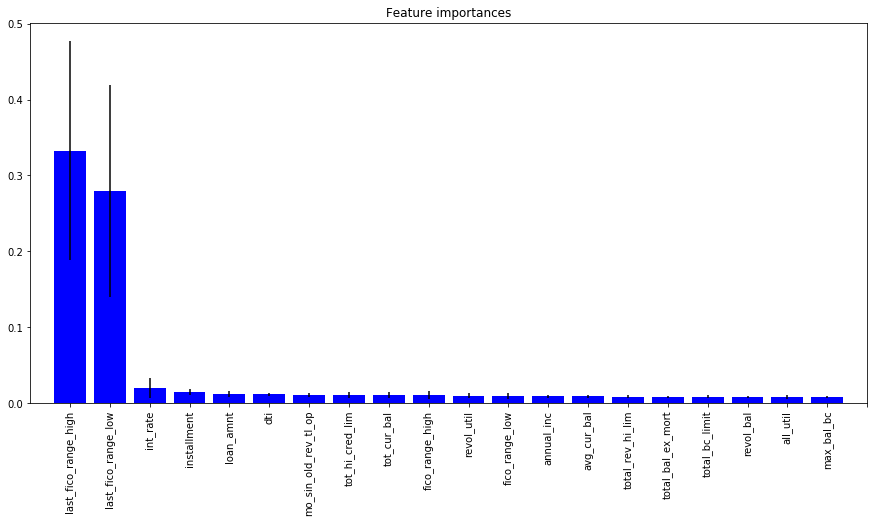

In [23]:
plt.rcParams['figure.figsize'] = (15,7)


def visualize_feature_importances(forest, ldf,X_train, X_test, y_train, y_test, n_features=20): 
    """
    Description: Display the model performance figures
    
    Input: 
        X_train, X_test, y_train, y_test - training and test data
        forest - predictive model
        ldf - model data
        n_features - number of features to visualize
    Output: 
        None
    """
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    hist_loan_df_x = ldf.drop(["loan_status"],axis=1)
    ordered_features =[]
    for f in range(n_features):
        ordered_features.append(hist_loan_df_x.columns[indices[f]])

    # Plot the impurity-based feature importances of the forest
    
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices[:n_features]],
            color="b", yerr=std[indices[:n_features]], align="center")
    plt.xticks(range(X_train.shape[1]), ordered_features)
    plt.xticks(rotation=90)
    plt.xlim([-1, n_features])
    plt.show()
    
visualize_feature_importances(forest, model_df,X_train, X_test, y_train, y_test)    



***ROC-Curve: reliability of the model***

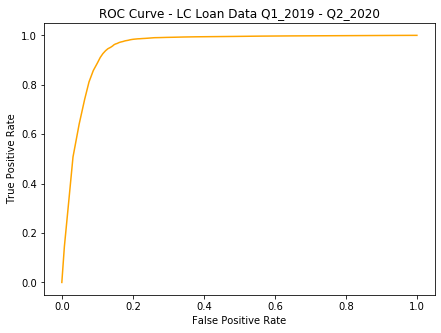

In [24]:
plt.rcParams['figure.figsize'] = (7,5)

def visualize_roc_curve(forest,X_test,y_test):
    """
    Description: Visualize roc-curve
    
    Input: 
        X_test, y_test -  test data
        forest - predictive model
        
    Output: 
        None
    """
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = forest.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    plt.plot(fpr, tpr, c='orange')
    plt.title("ROC Curve - LC Loan Data Q1_2019 - Q2_2020")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
visualize_roc_curve(forest,X_test,y_test)

***Model cross validation: performance and stability improvement***

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.0min finished


best parameters:
{'max_depth': None, 'n_estimators': 100}

Model Performance:
+----------+----------+----------+
|          | Train    | Test     |
|----------+----------+----------|
| f1-score | 99.999%  | 96.4421% |
| accuracy | 99.9984% | 94.3701% |
| roc_auc  | 99.9965% | 89.7127% |
+----------+----------+----------+


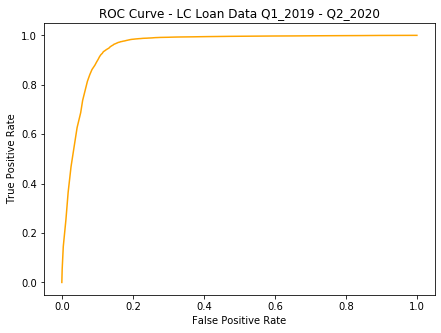

In [25]:
plt.rcParams['figure.figsize'] = (7,5)

def cross_validate_model(X_train, X_test, y_train, y_test):
    
    """
    Description: Run cross validation with GridSearchCV to determine an optimal model
    
    Input: 
        X_train, X_test, y_train, y_test - training and test data

    Output: 
        best_estimator_, best_params_ - best estimator and corresponding parameters
    """

    rfc = RandomForestClassifier(n_jobs=-1,max_depth=None ,n_estimators=50, random_state=42) 

    param_grid = { 
        'n_estimators': [50,100, 200],
        'max_depth': [15, 30, None]
    }

    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,scoring="accuracy", cv= 5, verbose=1, n_jobs=-1)
    CV_rfc.fit(X_train, y_train)
    print("best parameters:")
    print(CV_rfc.best_params_)
    print()
    return CV_rfc.best_estimator_, CV_rfc.best_params_ 

best_estimator, best_params = cross_validate_model(X_train, X_test, y_train, y_test)
display_model_performance(best_estimator,X_train, X_test, y_train, y_test, fit=False)
visualize_roc_curve(best_estimator,X_test,y_test)

## Conclusion<a class="anchor" id="chapter6"></a>

A significant improvement of the performance for predicting the outcome of LendingClub loans has been achieved with a highly reliable predictive model. The following results show this improvement and the reliability of the new model:

|             | **Fico Scoring** | **New Model (RF)** |
|:------------| :---------------:| -----------------: |
|**f1-score** | 93.40%           | 96.44%             |
|**accuracy** | 89.12%           | 94.37%             | 
|**roc_auc**  | -                | 89.71%             | 

The picture below on the right hand side shows how the roc-curve of a perfect model looks like (from working paper [Improving Classifier Performance Assessment of Credit Scoring Models](https://www.ucd.ie/geary/static/publications/workingpapers/gearywp201204.pdf) page 7). The picture of the roc-cuve below on the left hand side shows that the new model is nearly perfect in term of relialability and truthfulness.

![roc_reference](roc_auc_lc.jpg)

Different techniques have contribute to achieve the great results above. These include the smart choice of the relevant features, the meaninful removal of outliers, the use of an appropriate data visualization and a subsequent choice of the right classifier.
Features having a significant number of null-values (e.g. more than 2%) and those having the same value for more than a certain threshold (e.g. 85%) are not considered in the predictive model. Hence, the model is based on almost cleanly collected data. Both thresholds are model parameters which could be tunned to optimize the model. 
A threshold is also used to remove outliers in such a way that the distribution of the model data almost represents the general case. As this threshold is a model parameter, it could be tunned to optimize the model as well.
Visualizing the data with 3-dimensional t-SNE allows to view the real structure of the loan data. 

![t-SNE](t-sne.jpg)

In the current work, after the t-SNE visualization, it's clear that the prediction cannot work using linear models. The use of a decision three classifier or an ensemble classifier (e.g. Random Forest Classifier) appears to be right choice of the model.